## Prepare geometry files for time series analysis

1. concatenate multiple segments
2. downsample to the same size as dataset of interest (phase or offset), and save to the isce2 format
3. prepare water mask in radar-coordinates

#### Reference:
+ UAVSAR file format: https://uavsar.jpl.nasa.gov/science/documents/stack-format.html
+ cuDenseOffsets.py: https://github.com/isce-framework/isce2/blob/main/contrib/PyCuAmpcor/examples/cuDenseOffsets.py

In [1]:
%matplotlib inline
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
from mintpy.utils import readfile, writefile
plt.rcParams.update({'font.size': 12})

proj_dir  = os.path.expanduser('~/data/offset4motion/SanAndUav05016')
#proj_dir  = os.path.expanduser('~/data/offset4motion/SanAndUav09015')

os.chdir(proj_dir)
print('Go to directory:', proj_dir)

# inputs
dload_dir = os.path.join(proj_dir, 'download')
off_dir   = os.path.join(proj_dir, 'offsets')
template_file = glob.glob('mintpy_offset/{}.txt'.format(os.path.basename(proj_dir)))[0]

# output dir
geom_dir  = os.path.join(proj_dir, 'geometry')
os.makedirs(geom_dir, exist_ok=True)

Go to directory: /Users/yunjunz/data/offset4motion/SanAndUav05016


In [2]:
# link: https://uavsar.jpl.nasa.gov/science/documents/stack-format.html
ann_file = glob.glob(os.path.join(dload_dir, '*.ann'))[0]
ann_dict = readfile.read_uavsar_ann(ann_file)
num_seg = int(ann_dict['Number of Segments'])
# size info
length, width = 0, 0
for i in range(1,num_seg+1):
    length += int(ann_dict[f'slc_{i}_1x1 Rows'])
    width = int(ann_dict[f'slc_{i}_1x1 Columns'])
print(f'full size: {length} x {width}')
# flight info
site, line = os.path.splitext(os.path.basename(ann_file))[0].split('_')[:2]
ver, bcorr = os.path.splitext(os.path.basename(ann_file))[0].split('_')[-2:]

full size: 175235 x 9900


### 1. Concatenate the `*.lkv/llh` files

In [3]:
rerun = False
for fext in ['.lkv', '.llh']:
    out_file = os.path.join(dload_dir, f'{site}_{line}_{ver}_{bcorr}_2x8{fext}')
    if rerun or not os.path.isfile(out_file):
        for seg in range(1, num_seg+1):
            seg_file = os.path.join(dload_dir, f'{site}_{line}_{ver}_{bcorr}_s{seg}_2x8{fext}')
            with open(out_file, 'ab') as f:
                print(f'read data from file {os.path.basename(seg_file)} and append to file {os.path.basename(out_file)}')
                data = np.fromfile(seg_file, dtype=np.float32)
                f.write(data)

# output file names
lkv_file = os.path.join(dload_dir, f'{site}_{line}_{ver}_{bcorr}_2x8.lkv')
llh_file = os.path.join(dload_dir, f'{site}_{line}_{ver}_{bcorr}_2x8.llh')

### 2. Crop, resize and convert to `ISCE-2` format

In [4]:
# read Ampcor configuration
template = readfile.read_template(template_file)
win_wid, win_hgt = [int(x) for x in template['offset.winSize'].split(',')]
src_wid, src_hgt = [int(x) for x in template['offset.searchRange'].split(',')]
x_step, y_step   = [int(x) for x in template['offset.stepSize'].split(',')]

# crop index with respect to the full resolution geometry
# reference: PyCuAmpcor/examples/cuDenseOffset.py
margin = 0
x0 = margin + src_wid + int(win_wid / 2.)
y0 = margin + src_hgt + int(win_hgt / 2.)
x_num = (width  - 2*margin - 2*src_wid - win_wid) // x_step
y_num = (length - 2*margin - 2*src_hgt - win_hgt) // y_step

# crop index with respect to the multilooked geometry
rlooks, alooks = 2, 8
x0 = x0 // rlooks
y0 = y0 // alooks
x_step = x_step // rlooks
y_step = y_step // alooks

geom_dict = {
    'x_start' : x0,
    'y_start' : y0,
    'x_step'  : x_step,
    'y_step'  : y_step,
    'x_num'   : x_num,
    'y_num'   : y_num,
}
print(f'crop index: {geom_dict}')

geometry cropping index: {'x_start': 36, 'y_start': 33, 'x_step': 15, 'y_step': 15, 'x_num': 325, 'y_num': 1455}


In [5]:
# read and resize
# kwargs = dict(output_shape=(length, width), order=1, mode='edge', preserve_range=True)
lat   = readfile.read(llh_file, datasetName='latitude' )[0][y0::y_step, x0::x_step][:y_num, :x_num]
lon   = readfile.read(llh_file, datasetName='longitude')[0][y0::y_step, x0::x_step][:y_num, :x_num]
hgt   = readfile.read(llh_file, datasetName='height'   )[0][y0::y_step, x0::x_step][:y_num, :x_num]
lkv_e = readfile.read(lkv_file, datasetName='east'     )[0][y0::y_step, x0::x_step][:y_num, :x_num]
lkv_n = readfile.read(lkv_file, datasetName='north'    )[0][y0::y_step, x0::x_step][:y_num, :x_num]
lkv_u = readfile.read(lkv_file, datasetName='up'       )[0][y0::y_step, x0::x_step][:y_num, :x_num]

# normalize the look vector
lkv_amp = np.sqrt(lkv_e**2 + lkv_n**2 + lkv_u**2)
lkv_e /= lkv_amp
lkv_n /= lkv_amp
lkv_u /= lkv_amp

# look vector to LOS incidence and azimuth angle
inc_angle = np.rad2deg(np.arccos(lkv_u * -1))
az_angle = np.rad2deg(np.arcsin(lkv_e / np.sin(np.deg2rad(inc_angle)) * -1))

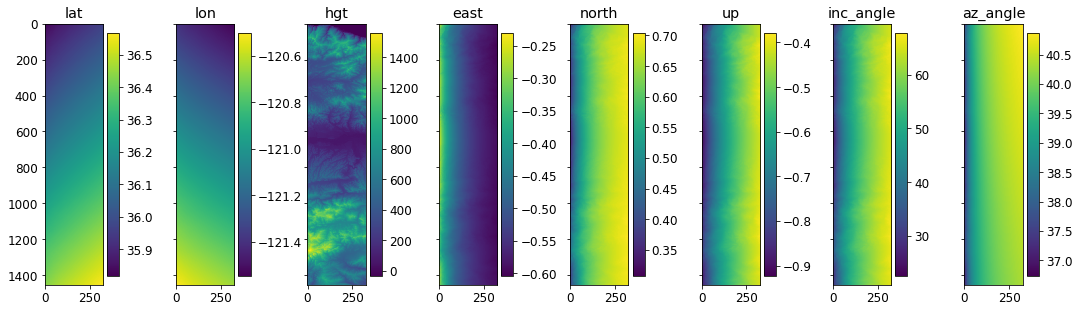

In [6]:
# plot
fig, axs = plt.subplots(nrows=1, ncols=8, figsize=[15, 4.5], sharey=True)
data_list = [lat, lon, hgt, lkv_e, lkv_n, lkv_u, inc_angle, az_angle]
title_list = ['lat', 'lon', 'hgt', 'east', 'north', 'up', 'inc_angle', 'az_angle']
for ax, data, title in zip(axs, data_list, title_list):
    im = ax.imshow(data, interpolation='nearest');  fig.colorbar(im, ax=ax);  ax.set_title(title)
fig.tight_layout()
plt.show()

In [7]:
# output
hgt_file = os.path.join(geom_dir, 'hgt.rdr')
lat_file = os.path.join(geom_dir, 'lat.rdr')
lon_file = os.path.join(geom_dir, 'lon.rdr')
los_file = os.path.join(geom_dir, 'los.rdr')

off_file = glob.glob(os.path.join(off_dir, '*/off*.bip'))[0]
meta = readfile.read_attribute(off_file)

meta['BANDS'] = '1'
meta['DATA_TYPE'] = 'float32'
meta['FILE_TYPE'] = 'hgt';  writefile.write(hgt, out_file=hgt_file, metadata=meta);  writefile.write_isce_xml(meta, hgt_file)
writefile.write(lat, out_file=lat_file, metadata=meta);  writefile.write_isce_xml(meta, lat_file)
writefile.write(lon, out_file=lon_file, metadata=meta);  writefile.write_isce_xml(meta, lon_file)
meta['BANDS'] = '2'
meta['INTERLEAVE'] = 'BIL'
ds_dict = {'incidenceAngle': inc_angle, 'azimuthAngle': az_angle}
writefile.write(ds_dict, out_file=los_file, metadata=meta);  writefile.write_isce_xml(meta, los_file)

write file: /Users/yunjunz/data/offset4motion/SanAndUav05016/geometry/hgt.rdr
write file: /Users/yunjunz/data/offset4motion/SanAndUav05016/geometry/hgt.rdr.rsc
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
write file: /Users/yunjunz/data/offset4motion/SanAndUav05016/geometry/hgt.rdr.xml
write file: /Users/yunjunz/data/offset4motion/SanAndUav05016/geometry/hgt.rdr.vrt
write file: /Users/yunjunz/data/offset4motion/SanAndUav05016/geometry/lat.rdr
write file: /Users/yunjunz/data/offset4motion/SanAndUav05016/geometry/lat.rdr.rsc
write file: /Users/yunjunz/data/offset4motion/SanAndUav05016/geometry/lat.rdr.xml
write file: /

### 3. Prepare `waterMask.rdr` file

In [8]:
dem_dir = os.path.join(proj_dir, 'DEM')
os.makedirs(dem_dir, exist_ok=True)

# download water mask in geo-coordinates
os.chdir(dem_dir)
s = np.floor(np.nanmin(lat));  n = np.ceil(np.nanmax(lat))
w = np.floor(np.nanmin(lon));  e = np.ceil(np.nanmax(lon))
cmd = f'wbd.py {s} {n} {w} {e}'
!{cmd}
os.chdir(proj_dir)

# radar-code the water mask
!geocode.py ./DEM/swbd*.wbd --lat-file ./geometry/lat.rdr --lon-file ./geometry/lon.rdr -o ./geometry/waterBody.h5 --geo2radar
!generate_mask.py ./geometry/waterBody.h5 -m -0.5 -o ./geometry/waterMask.rdr

setenv: Variable name must contain alphanumeric characters.
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
water body file: swbdLat_N35_N37_Lon_W122_W120.wbd
exists, do not download and correct
setenv: Variable name must contain alphanumeric characters.
No lookup table info range/lat found in files.
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: ./geometry/lat.rdr
input pixel size in (lat, lon) in degree: [-0.0002777777777777778, 0.0002777777777777778]
input area extent in (S, N, W, E) in degree: (35.00013888888889, 37.00013888888889, -122.00013888888